<a href="https://colab.research.google.com/github/yoojy31/pytorch-object-detection-tutorial/blob/main/tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
!cp "/content/drive/MyDrive/Colab_Notebooks/Data/PennFudanPed.zip" "/content/PennFudanPed.zip" 
!unzip -qq "/content/PennFudanPed.zip"
print(os.listdir('/content/PennFudanPed/'))

['PNGImages', 'Annotation', 'readme.txt', 'PedMasks', 'added-object-list.txt']


In [ ]:
%cd /content/drive/MyDrive/Colab_Notebooks
!git clone https://github.com/yoojy31/pytorch-object-detection-tutorial.git  # 외부에서 clone 해옴

/content/drive/MyDrive/Colab_Notebooks
fatal: destination path 'pytorch-object-detection-tutorial' already exists and is not an empty directory.


In [ ]:
# clone 해온 코드를 import 하기 위함
# 너무 복잡한 부분은 외부에서 불러오고, colab 에서는 생략

%cd 'pytorch-object-detection-tutorial'
import engine, utils
import transforms as T
%cd /content 

/content/drive/MyDrive/Colab_Notebooks/pytorch-object-detection-tutorial
/content


In [ ]:
# 필요한 라이브러리

import os
import sys
import math

import numpy as np
import torch
import torch.nn as nn
from PIL import Image

import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator, RPNHead
from torchvision.models.detection.faster_rcnn import TwoMLPHead, FastRCNNPredictor

In [ ]:
def main():  # 전체 코드 구조를 먼저 만든 후, 각 요소들을 만들 예정.
    # gpu 가 불가능하면 cpu 로 학습
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

    # Data Loader
    data_loader_train, data_loader_test = create_dataset_and_dataloader(root='PennFudanPed')

    # Model
    model = create_faster_rcnn() # (실습 1 : faster rcnn 의 각 구조를 직접 만들기)
    # model = create_pretrained_faster_rcnn() # (실습 2 : coco에서 학습된 faster rcnn 불러오기)
    
    model.to(device)

    # Optimizer
    params = [p for p in model.parameters() if p.requires_grad]
    optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

    # let's train it for 5 epochs
    num_epochs = 5
    for epoch in range(num_epochs):
        # train for one epoch, printing every 10 iterations
        train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
        # evaluate on the test dataset
        # eval 은 외부에서 가져옴
        engine.evaluate(model, data_loader_test, device=device)

    print("That's it!")
    return model

In [ ]:
def create_dataset_and_dataloader(root='PennFudanPed'):
  dataset = PennFudanDataset(root, get_transform(train=True))
  dataset_test = PennFudanDataset(root, get_transform(train=False))

  # split the dataset in train and test set
  indices = list(range(len(dataset)))
  dataset = torch.utils.data.Subset(dataset, indices[:-50])
  dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

  # define training and validation data loaders
  data_loader = torch.utils.data.DataLoader(
      dataset, batch_size=2, shuffle=True, num_workers=4,
      collate_fn=utils.collate_fn)

  data_loader_test = torch.utils.data.DataLoader(
      dataset_test, batch_size=1, shuffle=False, num_workers=4,
      collate_fn=utils.collate_fn)
  return data_loader, data_loader_test


In [ ]:
class PennFudanDataset(torch.utils.data.Dataset):
    '''
    PennFudanPed/
      PedMasks/
        FudanPed00001_mask.png
        FudanPed00002_mask.png
        FudanPed00003_mask.png
        FudanPed00004_mask.png
        ...
      PNGImages/
        FudanPed00001.png
        FudanPed00002.png
        FudanPed00003.png
        FudanPed00004.png
    '''
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # mask --> 0 : 배경, 1,2,3,... : 보행자 
        mask = np.array(mask) # convert the PIL Image into a numpy array
        
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:] # index 0 은 배경이라서 제거
        masks = mask == obj_ids[:, None, None]

        # mask 로부터 box를 생성  (left, top, right, bottom)
        num_objs = len(obj_ids) 
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # torch tensor 로 변환
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
  
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd


        # 데이터 변환
        # data augmentation, numpy array--> torch tensor, 기타등등....
        if self.transforms is not None:
            img, target = self.transforms(img, target)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [ ]:
def get_transform(train): # T 는 외부에서 불러오는 함수. clone 한 github code 에 포함
    transforms = []
    transforms.append(T.ToTensor())
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


{'boxes': tensor([[[235., 122., 321., 411.],
         [131., 105., 234., 391.],
         [ 13., 106., 133., 386.]]]), 'labels': tensor([[1, 1, 1]]), 'masks': tensor([[[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],

         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]]]], dtype=torch.uint8), 'image_id': tensor([[48]]), 'area': tensor([[24854., 29458., 33600.]]), 'iscrowd': tensor([[0, 0, 0]])}


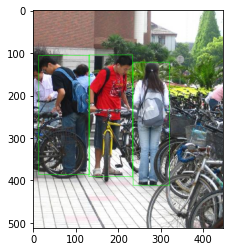

In [ ]:
# 데이터 테스트 출력
def tmp_test_dataloader():
  import cv2
  import matplotlib.pyplot as plt

  # 박스 시각화
  def makeBox(voc_im, bbox):
    image = voc_im.copy()
    for i in range(len(bbox)):
      cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
    return image


  dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
  dataloader = torch.utils.data.DataLoader(dataset, shuffle=True)

  for i, (image, targets) in enumerate(dataloader):
    test_image = image
    test_target = targets
    if i == 0 : break

  print(test_target)

  plot_image = makeBox(test_image.squeeze(0).permute(1,2,0).numpy(),test_target['boxes'].squeeze(0))
  plt.imshow(plot_image)

tmp_test_dataloader()

In [ ]:
def create_faster_rcnn():
    resnet = torchvision.models.resnet50(pretrained=True)
    backbone = nn.Sequential(
        resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
        resnet.layer1, resnet.layer2, resnet.layer3,
    )
    # print(backbone(torch.rand(8, 3, 800, 800)).shape)
    backbone.out_channels = 1024

    rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))

    num_anchors = 5 * 3
    in_channels = backbone.out_channels
    rpn_head = RPNHead(in_channels, num_anchors)
    # prob, box_delta = rpn_head([torch.rand(8, 1024, 50, 50)])
    # print(box_delta[0].shape, prob[0].shape)

    roi_pooler = torchvision.ops.MultiScaleRoIAlign(
        featmap_names=['0'], output_size=7, sampling_ratio=2)
    # print(roi_pooler(
    #     x={'0': torch.rand(8, 1024, 50, 50)},
    #     boxes=[torch.randint(0, 800, size=(100, 4)).float()] * 8,
    #     image_shapes=[(800, 800)] * 8).shape)

    in_channles = 7 * 7 * backbone.out_channels
    representation_size = 2048
    box_base = TwoMLPHead(in_channels=in_channles,
                          representation_size=representation_size)
    # print(box_base(torch.rand(800, 1024, 7, 7)).shape)

    num_classes = 2
    box_predictor = FastRCNNPredictor(in_channels=representation_size, num_classes=num_classes)
    # prob, box_delta = box_predictor(torch.rand(800, 2048))
    # print(prob.shape, box_delta.shape)

    # put the pieces together inside a FasterRCNN model
    model = FasterRCNN(backbone,
                       # num_classes=2,
                       rpn_head=rpn_head,
                       rpn_anchor_generator=rpn_anchor_generator,
                       box_roi_pool=roi_pooler,
                       box_head=box_base,
                       box_predictor=box_predictor)
    return model

In [ ]:
@torch.no_grad()
def tmp_test_backbone():
  resnet = torchvision.models.resnet50(pretrained=True)
  backbone = nn.Sequential(
      resnet.conv1, resnet.bn1, resnet.relu, resnet.maxpool,
      resnet.layer1, resnet.layer2, resnet.layer3,
  )

  input_img = torch.rand(8, 3, 800, 800)
  output_feature = backbone(input_img)
  print('input : image batch {}'.format(input_img.shape))
  print('output : backbone feature {}'.format(output_feature.shape))

tmp_test_backbone()

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


input : image batch torch.Size([8, 3, 800, 800])
output : backbone feature torch.Size([8, 1024, 50, 50])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


input : images, features  torch.Size([1, 3, 800, 800]), torch.Size([1, 1024, 50, 50])
output : anchors  torch.Size([37500, 4])
tensor([[ 761.,  773.,  807.,  795.],
        [ 739.,  761.,  829.,  807.],
        [ 693.,  739.,  875.,  829.],
        [ 603.,  693.,  965.,  875.],
        [ 422.,  603., 1146.,  965.],
        [ 768.,  768.,  800.,  800.],
        [ 752.,  752.,  816.,  816.],
        [ 720.,  720.,  848.,  848.],
        [ 656.,  656.,  912.,  912.],
        [ 528.,  528., 1040., 1040.],
        [ 773.,  761.,  795.,  807.],
        [ 761.,  739.,  807.,  829.],
        [ 739.,  693.,  829.,  875.],
        [ 693.,  603.,  875.,  965.],
        [ 603.,  422.,  965., 1146.]])


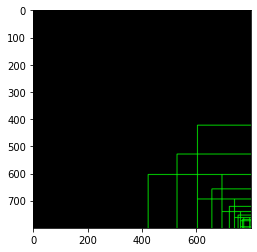

In [ ]:
@torch.no_grad()
def tmp_test_anchor_generator(draw_index):
  import cv2
  import matplotlib.pyplot as plt

  rpn_anchor_generator = AnchorGenerator(
        sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),))
  rpn_anchor_generator.to('cpu')
  
  images = torch.rand(1, 3, 800, 800)
  features = torch.rand(1, 1024, 50, 50)

  from torchvision.models.detection.image_list import ImageList
  images = ImageList(images, [(800, 800)])

  anchors = rpn_anchor_generator(images, features)

  print('input : images, features  {}, {}'.format(images.tensors.shape, features.shape))
  print('output : anchors  {}'.format(anchors[0].shape)) # 37,500 == 50x50 x 15
  
  draw_img = torch.zeros(800, 800, 3).numpy()
  # 박스 시각화
  def makeBox(voc_im, bbox):
    image = voc_im.copy()
    for i in range(len(bbox)):
      cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 2)
    return image

  selected_boxes = anchors[0][draw_index:draw_index+15]

  print(selected_boxes)
  plot_image = makeBox(draw_img, selected_boxes)
  plt.imshow(plot_image)

tmp_test_anchor_generator(37485) # 0, 15, 30, 45, .... , 37485 까지 임의의 넣어볼 것

In [ ]:
@torch.no_grad()
def tmp_test_RPNHead():
  rpn_head = RPNHead(in_channels=1024, num_anchors=5*3) # 1024 : backbone의 output channel

  backbone_feature_map = torch.rand(8, 1024, 50, 50)

  prob, box_delta = rpn_head([backbone_feature_map])
  print('intput : backbone feature {}'.format(backbone_feature_map.shape))
  print('output : prob {}  and  box_delta {}'.format(prob[0].shape, box_delta[0].shape))

tmp_test_RPNHead()

intput : backbone feature torch.Size([8, 1024, 50, 50])
output : prob torch.Size([8, 15, 50, 50])  and  box_delta torch.Size([8, 60, 50, 50])


In [ ]:
@torch.no_grad()
def tmp_test_RoIAlign():
  roi_pooler = torchvision.ops.MultiScaleRoIAlign(
          featmap_names=['0'], output_size=7, sampling_ratio=2)

  backbone_feature_map = torch.rand(8, 1024, 50, 50)
  box_of_rpn = [torch.randint(0, 800, size=(100, 4)).float()] * 8
  print('[input]')
  print('backbone feature  {}'.format(backbone_feature_map.shape))
  print('box :  batch {}  and  shape : {}'.format(len(box_of_rpn), box_of_rpn[0].shape))
  print()
  print('output : ', roi_pooler(
      x={'0': backbone_feature_map},
      boxes=box_of_rpn,
      image_shapes=[(800, 800)] * 8).shape)
  
tmp_test_RoIAlign()

[input]
backbone feature  torch.Size([8, 1024, 50, 50])
box :  batch 8  and  shape : torch.Size([100, 4])

output :  torch.Size([800, 1024, 7, 7])


In [ ]:
@torch.no_grad()
def tmp_test_boxbase():
  box_base = TwoMLPHead(in_channels=7*7*1024,
                            representation_size=2048)

  roi_pooling_result = torch.rand(800, 1024, 7, 7)
  output = box_base(roi_pooling_result)

  print('input : roi pooling result  {}'.format(roi_pooling_result.shape))
  print('output : box base feature  {}'.format(output.shape))

tmp_test_boxbase()

input : roi pooling result  torch.Size([800, 1024, 7, 7])
output : box base feature  torch.Size([800, 2048])


In [ ]:
@torch.no_grad()
def tmp_test_boxpredictor():
  num_classes = 2
  box_predictor = FastRCNNPredictor(in_channels=2048, num_classes=num_classes)

  box_base_result = torch.rand(800, 2048)
  prob, box_delta = box_predictor(box_base_result)

  print('input : roi pooling result  {}'.format(box_base_result.shape))
  print('output : box prob  {}   and    box delta {}'.format(prob.shape, box_delta.shape))

tmp_test_boxpredictor()

input : roi pooling result  torch.Size([800, 2048])
output : box prob  torch.Size([800, 2])   and    box delta torch.Size([800, 8])


In [ ]:
def create_pretrained_faster_rcnn():
    # COCO 에서 학습된 weight 를 불러오기
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # COCO는 80 클래스. 클래스 개수가 달라졌기에 클래스 분류 layer 를 교체해줘야 함.
    num_classes = 2  # 1 class (person) + background
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [ ]:
def create_pretrained_ssd():
    model = torchvision.models.detection.ssdlite320_mobilenet_v3_large(pretrained=True)
    # feature_maps = model.backbone(torch.rand(4, 3, 320, 320))
    # print(len(feature_maps), feature_maps.keys())
    # print(feature_maps['0'].shape, feature_maps['1'].shape, feature_maps['2'].shape,
    #       feature_maps['3'].shape, feature_maps['4'].shape, feature_maps['5'].shape)
    # out = model.head(list(feature_maps.values()))
    # print(out['bbox_regression'].shape, out['cls_logits'].shape)
    return model

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()

    metric_logger = utils.MetricLogger(delimiter="  ") # 학습할 때 가독성 좋은 log 를 위해 사용
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        # train 할 때는 input image 와 target 이 필요
        # 현재 사용하는 네트워크에 맞게 transform
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        # loss 계산 후 backward  &  파라미터 update
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if not math.isfinite(losses.item()): # loss 가 무한대 되면 강제 정지
            print("Loss is {}, stopping training".format(losses.item()))
            print(loss_dict)
            sys.exit(1)

        # 학습 과정 log
        metric_logger.update(loss=losses, **loss_dict)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

In [ ]:
if __name__ == "__main__":
    model = main()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: [0]  [ 0/60]  eta: 0:02:15  lr: 0.005000  loss: 1.5258 (1.5258)  loss_classifier: 0.6969 (0.6969)  loss_box_reg: 0.0423 (0.0423)  loss_objectness: 0.6943 (0.6943)  loss_rpn_box_reg: 0.0923 (0.0923)  time: 2.2587  data: 0.4115  max mem: 4461
Epoch: [0]  [10/60]  eta: 0:01:08  lr: 0.005000  loss: 1.5258 (1.4948)  loss_classifier: 0.5986 (0.5965)  loss_box_reg: 0.0477 (0.1085)  loss_objectness: 0.6867 (0.6873)  loss_rpn_box_reg: 0.0982 (0.1025)  time: 1.3632  data: 0.0455  max mem: 5637
Epoch: [0]  [20/60]  eta: 0:00:50  lr: 0.005000  loss: 1.4658 (1.4880)  loss_classifier: 0.4662 (0.5025)  loss_box_reg: 0.2093 (0.2134)  loss_objectness: 0.6828 (0.6798)  loss_rpn_box_reg: 0.0745 (0.0923)  time: 1.2150  data: 0.0111  max mem: 5637
Epoch: [0]  [30/60]  eta: 0:00:36  lr: 0.005000  loss: 1.3935 (1.4338)  loss_classifier: 0.3670 (0.4408)  loss_box_reg: 0.3115 (0.2325)  loss_objectness: 0.6584 (0.6696)  loss_rpn_box_reg: 0.0744 (0.0909)  time: 1.1619  data: 0.0131  max mem: 5637
Epoch: [

In [ ]:
# test data 중 한 장을 가져와서 시각화

data_path = os.path.join('/content/PennFudanPed/PNGImages')
file_list = list(sorted(os.listdir(data_path)))
test_img_path = os.path.join(data_path, file_list[-1])
print(test_img_path)

/content/PennFudanPed/PNGImages/PennPed00096.png


In [ ]:
model.eval()

img_path = test_img_path
images = np.array(Image.open(img_path).convert("RGB"))
images = torch.from_numpy(images/255.0).permute(2,0,1).unsqueeze(0).float()
print(images.shape)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

images = list(image.to(device) for image in images)
with torch.no_grad():
  output_dict = model(images)
print(output_dict) 
print(output_dict[0].keys())

torch.Size([1, 3, 331, 294])
[{'boxes': tensor([[117.6240, 121.4598, 181.9873, 314.0774],
        [  8.7124,  64.2745, 104.8817, 297.2342],
        [100.0300,  62.0385, 198.9773, 307.3481],
        [ 17.0048, 104.1680,  75.5249, 309.3172],
        [ 45.4616,  67.9857, 109.7909, 235.4335],
        [135.6784,  96.5484, 196.9722, 269.3991],
        [ 71.8899,  61.8055, 132.3231, 232.5237],
        [  4.2194,  77.9603,  52.2144, 264.9451],
        [ 92.0704,  47.0013, 157.0172, 261.7572],
        [165.5054,  45.6270, 221.9187, 217.5258],
        [ 38.9371,  49.5767, 149.9766, 270.3344]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.8702, 0.8445, 0.7904, 0.4175, 0.3483, 0.3062, 0.2003, 0.1729, 0.1514,
        0.1121, 0.0890], device='cuda:0')}]
dict_keys(['boxes', 'labels', 'scores'])


In [ ]:
# 시각화를 위해서 output 을 numpy 로
boxes = output_dict[0]['boxes'].detach().cpu().numpy()
scores = output_dict[0]['scores'].detach().cpu().numpy()
labels = output_dict[0]['labels'].detach().cpu().numpy()

In [ ]:
# score threshold   0.01 v.s. 0.5
# faster rcnn 안에 후처리가 포함되어 있지만, 사용자가 추가로 thresholding 가능

scores_threshold = 0.01  # 0.5
select_idxes = scores > scores_threshold
print(select_idxes)

[ True  True  True  True  True  True  True  True  True  True  True]


In [ ]:
# score thresholding 후 남은 것들만
selected_boxes = boxes[select_idxes].astype(np.int)
selected_scores = scores[select_idxes]
selected_labels = labels[select_idxes]

In [ ]:
print(selected_boxes.shape, boxes.shape)  # thresohold 전후

(11, 4) (11, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[117 121 181 314]
 [  8  64 104 297]
 [100  62 198 307]
 [ 17 104  75 309]
 [ 45  67 109 235]
 [135  96 196 269]
 [ 71  61 132 232]
 [  4  77  52 264]
 [ 92  47 157 261]
 [165  45 221 217]
 [ 38  49 149 270]]


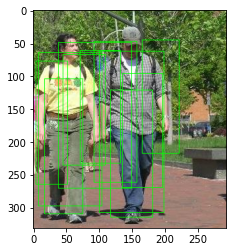

In [ ]:
# 데이터 테스트 출력

import cv2
import matplotlib.pyplot as plt

# 박스 시각화
def makeBox(voc_im, bbox):
  image = voc_im.copy()
  for i in range(len(bbox)):
    cv2.rectangle(image,(int(bbox[i][0]),int(bbox[i][1])),(int(bbox[i][2]),int(bbox[i][3])),color = (0,255,0),thickness = 1)
  return image

draw_img = images[0].permute(1, 2, 0).cpu().numpy()
print(selected_boxes)
plot_image = makeBox(draw_img, selected_boxes)
plt.imshow(plot_image)

[실습]

- main 문에서 모델을 바꿔서 AP 성능 비교
  - model = create_faster_rcnn()
  - model = create_pretrained_faster_rcnn()

- threshold 를 바꿔가며 시각화